<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [6]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [7]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [8]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [9]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1])

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [10]:
#unshuffled = np.array(data_)

In [11]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [12]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [13]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=10)

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [17]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 702)

In [52]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/5)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [64]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [65]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr=.0001)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

In [66]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[0.9965],
          [0.9861],
          [0.9907],
          ...,
          [1.0114],
          [0.9877],
          [1.0062]],
 
         [[0.9862],
          [1.0067],
          [1.0135],
          ...,
          [0.9821],
          [1.0079],
          [0.9869]],
 
         [[1.0231],
          [1.0066],
          [1.0066],
          ...,
          [1.0245],
          [1.0038],
          [1.0049]],
 
         ...,
 
         [[0.9821],
          [0.9852],
          [0.9882],
          ...,
          [0.9779],
          [0.9707],
          [0.9912]],
 
         [[1.0084],
          [0.9647],
          [0.9781],
          ...,
          [0.9940],
          [0.9892],
          [1.0034]],
 
         [[0.9966],
          [1.0137],
          [0.9894],
          ...,
          [1.0000],
          [0.9916],
          [0.9987]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[-0.0066,  0.0067,  0.0516,  ..., -0.0323,  0.0022,  0.0345]],
 
         [[ 0.0104, -0.0032,  0.0171,

## Training 

In [67]:
from tqdm import tqdm

In [ ]:
from sam import SAM

base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.001, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

    


  0%|          | 3/5800 [00:00<04:03, 23.76it/s]

 iteration 0, train cost 1.5480, valid cost 1.5969


  1%|          | 54/5800 [00:02<03:31, 27.16it/s]

 iteration 50, train cost 1.0943, valid cost 1.1087


  2%|▏         | 105/5800 [00:03<03:30, 27.04it/s]

 iteration 100, train cost 0.9092, valid cost 0.9479


  3%|▎         | 156/5800 [00:05<03:23, 27.73it/s]

 iteration 150, train cost 0.9060, valid cost 0.9451


  4%|▎         | 204/5800 [00:07<03:27, 26.94it/s]

 iteration 200, train cost 0.9044, valid cost 0.9438


  4%|▍         | 256/5800 [00:09<03:22, 27.36it/s]

 iteration 250, train cost 0.9033, valid cost 0.9424


  5%|▌         | 304/5800 [00:11<03:22, 27.12it/s]

 iteration 300, train cost 0.9011, valid cost 0.9409


  6%|▌         | 355/5800 [00:13<03:19, 27.25it/s]

 iteration 350, train cost 0.8980, valid cost 0.9379


  7%|▋         | 406/5800 [00:15<03:19, 27.09it/s]

 iteration 400, train cost 0.8877, valid cost 0.9288


  8%|▊         | 454/5800 [00:16<03:17, 27.12it/s]

 iteration 450, train cost 0.8491, valid cost 0.8895


  9%|▊         | 505/5800 [00:18<03:17, 26.82it/s]

 iteration 500, train cost 0.8027, valid cost 0.8437


 10%|▉         | 556/5800 [00:20<03:10, 27.55it/s]

 iteration 550, train cost 0.7748, valid cost 0.8152


 10%|█         | 604/5800 [00:22<03:11, 27.11it/s]

 iteration 600, train cost 0.7511, valid cost 0.7900


 11%|█▏        | 655/5800 [00:24<03:10, 27.07it/s]

 iteration 650, train cost 0.7417, valid cost 0.7814


 12%|█▏        | 706/5800 [00:26<03:10, 26.77it/s]

 iteration 700, train cost 0.7370, valid cost 0.7772


 13%|█▎        | 754/5800 [00:28<03:07, 26.93it/s]

 iteration 750, train cost 0.7302, valid cost 0.7709


 14%|█▍        | 805/5800 [00:29<03:04, 27.14it/s]

 iteration 800, train cost 0.7169, valid cost 0.7572


 15%|█▍        | 856/5800 [00:31<03:03, 27.01it/s]

 iteration 850, train cost 0.7045, valid cost 0.7456


 16%|█▌        | 904/5800 [00:33<03:00, 27.12it/s]

 iteration 900, train cost 0.6974, valid cost 0.7397


 16%|█▋        | 955/5800 [00:35<02:58, 27.16it/s]

 iteration 950, train cost 0.6904, valid cost 0.7354


 17%|█▋        | 1006/5800 [00:37<02:57, 26.98it/s]

 iteration 1000, train cost 0.6824, valid cost 0.7294


 18%|█▊        | 1054/5800 [00:39<02:55, 26.97it/s]

 iteration 1050, train cost 0.6726, valid cost 0.7214


 19%|█▉        | 1105/5800 [00:41<02:53, 27.12it/s]

 iteration 1100, train cost 0.6616, valid cost 0.7125


 20%|█▉        | 1156/5800 [00:42<02:53, 26.83it/s]

 iteration 1150, train cost 0.6510, valid cost 0.7046


 21%|██        | 1204/5800 [00:44<02:52, 26.57it/s]

 iteration 1200, train cost 0.6403, valid cost 0.6976


 22%|██▏       | 1255/5800 [00:46<02:51, 26.49it/s]

 iteration 1250, train cost 0.6317, valid cost 0.6911


 23%|██▎       | 1306/5800 [00:48<02:47, 26.77it/s]

 iteration 1300, train cost 0.6235, valid cost 0.6847


 23%|██▎       | 1354/5800 [00:50<02:44, 27.04it/s]

 iteration 1350, train cost 0.6150, valid cost 0.6786


 24%|██▍       | 1405/5800 [00:52<02:41, 27.13it/s]

 iteration 1400, train cost 0.6074, valid cost 0.6730


 25%|██▌       | 1456/5800 [00:54<02:41, 26.90it/s]

 iteration 1450, train cost 0.6005, valid cost 0.6683


 26%|██▌       | 1504/5800 [00:56<02:38, 27.12it/s]

 iteration 1500, train cost 0.5942, valid cost 0.6639


 27%|██▋       | 1555/5800 [00:57<02:37, 27.02it/s]

 iteration 1550, train cost 0.5876, valid cost 0.6592


 28%|██▊       | 1606/5800 [00:59<02:35, 26.89it/s]

 iteration 1600, train cost 0.5801, valid cost 0.6538


 29%|██▊       | 1654/5800 [01:01<02:33, 26.99it/s]

 iteration 1650, train cost 0.5724, valid cost 0.6480


 29%|██▉       | 1705/5800 [01:03<02:32, 26.94it/s]

 iteration 1700, train cost 0.5647, valid cost 0.6420


 30%|███       | 1756/5800 [01:05<02:26, 27.62it/s]

 iteration 1750, train cost 0.5579, valid cost 0.6369


 31%|███       | 1804/5800 [01:07<02:28, 26.87it/s]

 iteration 1800, train cost 0.5503, valid cost 0.6320


 32%|███▏      | 1855/5800 [01:09<02:24, 27.26it/s]

 iteration 1850, train cost 0.5442, valid cost 0.6281


 33%|███▎      | 1906/5800 [01:10<02:25, 26.75it/s]

 iteration 1900, train cost 0.5376, valid cost 0.6243


 34%|███▎      | 1954/5800 [01:12<02:22, 27.07it/s]

 iteration 1950, train cost 0.5320, valid cost 0.6205


 35%|███▍      | 2005/5800 [01:14<02:20, 26.94it/s]

 iteration 2000, train cost 0.5279, valid cost 0.6172


 35%|███▌      | 2056/5800 [01:16<02:16, 27.35it/s]

 iteration 2050, train cost 0.5214, valid cost 0.6141


 36%|███▋      | 2104/5800 [01:18<02:17, 26.88it/s]

 iteration 2100, train cost 0.5165, valid cost 0.6111


 37%|███▋      | 2155/5800 [01:20<02:14, 27.01it/s]

 iteration 2150, train cost 0.5114, valid cost 0.6092


 38%|███▊      | 2206/5800 [01:22<02:12, 27.14it/s]

 iteration 2200, train cost 0.5062, valid cost 0.6066


 39%|███▉      | 2254/5800 [01:23<02:11, 26.88it/s]

 iteration 2250, train cost 0.5019, valid cost 0.6043


 40%|███▉      | 2305/5800 [01:25<02:11, 26.64it/s]

 iteration 2300, train cost 0.4984, valid cost 0.6021


 41%|████      | 2356/5800 [01:27<02:09, 26.54it/s]

 iteration 2350, train cost 0.4934, valid cost 0.6001


 41%|████▏     | 2404/5800 [01:29<02:06, 26.78it/s]

 iteration 2400, train cost 0.4887, valid cost 0.5975


 42%|████▏     | 2455/5800 [01:31<02:03, 27.03it/s]

 iteration 2450, train cost 0.4844, valid cost 0.5954


 43%|████▎     | 2506/5800 [01:33<02:01, 27.16it/s]

 iteration 2500, train cost 0.4798, valid cost 0.5935


 44%|████▍     | 2554/5800 [01:35<02:02, 26.59it/s]

 iteration 2550, train cost 0.4747, valid cost 0.5917


 45%|████▍     | 2605/5800 [01:37<01:58, 26.90it/s]

 iteration 2600, train cost 0.4712, valid cost 0.5896


 46%|████▌     | 2656/5800 [01:39<01:58, 26.55it/s]

 iteration 2650, train cost 0.4663, valid cost 0.5881


 47%|████▋     | 2704/5800 [01:40<01:54, 27.04it/s]

 iteration 2700, train cost 0.4630, valid cost 0.5865


 48%|████▊     | 2755/5800 [01:42<01:55, 26.34it/s]

 iteration 2750, train cost 0.4591, valid cost 0.5851


 48%|████▊     | 2806/5800 [01:44<01:51, 26.85it/s]

 iteration 2800, train cost 0.4545, valid cost 0.5834


 49%|████▉     | 2854/5800 [01:46<01:49, 26.83it/s]

 iteration 2850, train cost 0.4502, valid cost 0.5826


 50%|█████     | 2905/5800 [01:48<01:48, 26.75it/s]

 iteration 2900, train cost 0.4472, valid cost 0.5810


 51%|█████     | 2953/5800 [01:50<01:46, 26.66it/s]

 iteration 2950, train cost 0.4440, valid cost 0.5796


 52%|█████▏    | 3005/5800 [01:52<01:43, 26.93it/s]

 iteration 3000, train cost 0.4399, valid cost 0.5788


 53%|█████▎    | 3056/5800 [01:54<01:42, 26.84it/s]

 iteration 3050, train cost 0.4361, valid cost 0.5776


 54%|█████▎    | 3104/5800 [01:55<01:39, 26.96it/s]

 iteration 3100, train cost 0.4324, valid cost 0.5762


 54%|█████▍    | 3155/5800 [01:57<01:38, 26.81it/s]

 iteration 3150, train cost 0.4280, valid cost 0.5754


 55%|█████▌    | 3206/5800 [01:59<01:36, 26.94it/s]

 iteration 3200, train cost 0.4247, valid cost 0.5743


 56%|█████▌    | 3254/5800 [02:01<01:34, 26.96it/s]

 iteration 3250, train cost 0.4214, valid cost 0.5733


 57%|█████▋    | 3305/5800 [02:03<01:34, 26.53it/s]

 iteration 3300, train cost 0.4178, valid cost 0.5727


 58%|█████▊    | 3356/5800 [02:05<01:32, 26.29it/s]

 iteration 3350, train cost 0.4149, valid cost 0.5711


 59%|█████▊    | 3404/5800 [02:07<01:30, 26.57it/s]

 iteration 3400, train cost 0.4115, valid cost 0.5709


 60%|█████▉    | 3455/5800 [02:09<01:26, 27.25it/s]

 iteration 3450, train cost 0.4082, valid cost 0.5703


 60%|██████    | 3506/5800 [02:10<01:26, 26.55it/s]

 iteration 3500, train cost 0.4050, valid cost 0.5689


 61%|██████▏   | 3554/5800 [02:12<01:22, 27.34it/s]

 iteration 3550, train cost 0.4012, valid cost 0.5679


 62%|██████▏   | 3605/5800 [02:14<01:22, 26.53it/s]

 iteration 3600, train cost 0.3984, valid cost 0.5673


 63%|██████▎   | 3656/5800 [02:16<01:20, 26.52it/s]

 iteration 3650, train cost 0.3959, valid cost 0.5668


 64%|██████▍   | 3704/5800 [02:18<01:18, 26.55it/s]

 iteration 3700, train cost 0.3934, valid cost 0.5658


 65%|██████▍   | 3755/5800 [02:20<01:15, 27.09it/s]

 iteration 3750, train cost 0.3907, valid cost 0.5649


 66%|██████▌   | 3806/5800 [02:22<01:14, 26.94it/s]

 iteration 3800, train cost 0.3864, valid cost 0.5651


 66%|██████▋   | 3854/5800 [02:23<01:12, 26.87it/s]

 iteration 3850, train cost 0.3852, valid cost 0.5642


 67%|██████▋   | 3905/5800 [02:25<01:11, 26.59it/s]

 iteration 3900, train cost 0.3811, valid cost 0.5631


 68%|██████▊   | 3956/5800 [02:27<01:08, 26.97it/s]

 iteration 3950, train cost 0.3782, valid cost 0.5626


 69%|██████▉   | 4004/5800 [02:29<01:06, 27.08it/s]

 iteration 4000, train cost 0.3754, valid cost 0.5614


 70%|██████▉   | 4055/5800 [02:31<01:04, 27.22it/s]

 iteration 4050, train cost 0.3736, valid cost 0.5609


 71%|███████   | 4106/5800 [02:33<01:02, 27.10it/s]

 iteration 4100, train cost 0.3703, valid cost 0.5606


 72%|███████▏  | 4154/5800 [02:35<01:00, 27.30it/s]

 iteration 4150, train cost 0.3679, valid cost 0.5599


 72%|███████▎  | 4205/5800 [02:36<00:58, 27.38it/s]

 iteration 4200, train cost 0.3650, valid cost 0.5598


 73%|███████▎  | 4256/5800 [02:38<00:57, 27.09it/s]

 iteration 4250, train cost 0.3627, valid cost 0.5580


 74%|███████▍  | 4304/5800 [02:40<00:54, 27.20it/s]

 iteration 4300, train cost 0.3602, valid cost 0.5579


 75%|███████▌  | 4355/5800 [02:42<00:52, 27.40it/s]

 iteration 4350, train cost 0.3581, valid cost 0.5578


 76%|███████▌  | 4406/5800 [02:44<00:51, 27.12it/s]

 iteration 4400, train cost 0.3562, valid cost 0.5566


In [ ]:
"""
### Original training
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()
    

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

""";  

### Validation from same neurons

In [58]:
test, hidden = net(x1_valid)

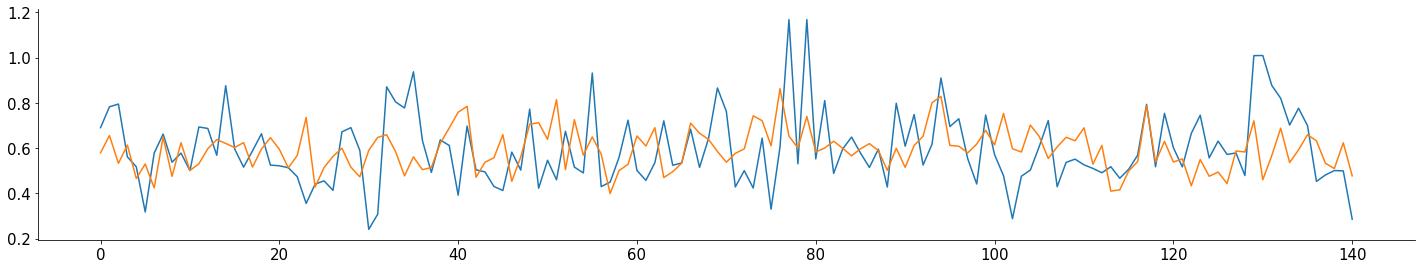

In [59]:
plt.plot(x2_valid[2,:,0].cpu().detach().numpy())
plt.plot(test[2,:,0].cpu().detach().numpy())

## Testing neurons from same layer

In [60]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[n_neurs:2*n_neurs,:]).unsqueeze(2).to(device).float())

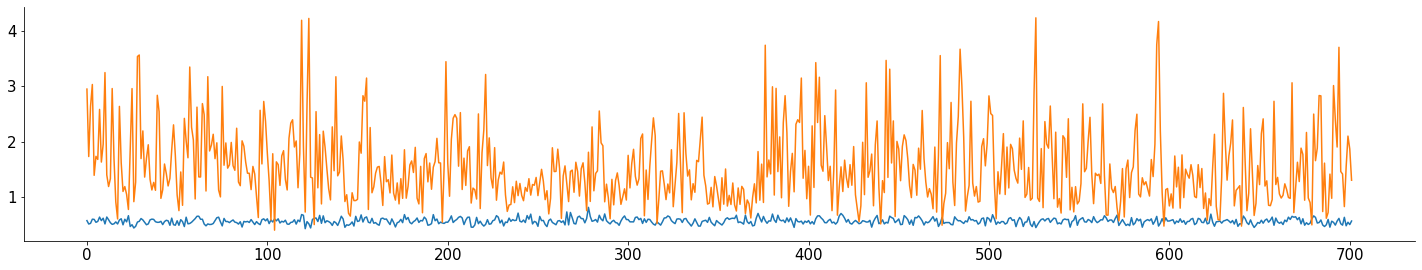

In [61]:
plt.plot(test[10,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[110,:])

## Testing neurons from another layer (#9)

In [ ]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[10000:10100,:]).unsqueeze(2).to(device).float())

In [ ]:
plt.plot(test[10,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[10010,:])

# Training 9 Networks 
Each Network corresponds to a different layer in V1

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 10000
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

    